In [ ]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


In [1]:
import warnings
import os
with warnings.catch_warnings():
    
    from scipy.integrate import odeint
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    import numpy as np
    from jax import grad 
    from jax.experimental.ode import odeint as jodeint
    import jax.numpy as jnp
    import dask.array as da
    from scipy.linalg import svd
    
    from simulai.regression import OpInf, KoopmanOperator
    from simulai.math.integration import RK4, LSODA, FunctionWrapper, ClassWrapper
    from simulai.metrics import LyapunovUnits
    from simulai.math.differentiation import CollocationDerivative
    from simulai.rom import POD
    from simulai.metrics import L2Norm

/home/jalmeida/.conda/envs/appsimulai/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def explained_variance(s, n=-1):
    return np.cumsum(np.square(s[:n]))/np.sum(np.square(s))

In [3]:
def NRMSE(exact, approximated):
    return np.sqrt(np.mean(np.square(exact - approximated)/exact.std(axis=0)**2, axis=1))

In [4]:
def NRSE(exact, approximated):
    return np.sqrt(np.square(exact - approximated)/exact.std(axis=0)**2)

In [5]:
save_path = '/tmp'
tol = 0.5
# These are our constants
N = 40 # Number of variables
K = 37
F = 10 #8  # Forcing

label = f"n_{N}_F_{F}_svd"

if F==8:
    lambda_1 = 1.68
else:
    lambda_1 = 2.27

In [6]:
def Lorenz96(x, t):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

def vec_Lorenz96(x, t):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros((x.shape[0], N))
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[:, i] = (x[:, (i + 1) % N] - x[:, i - 2]) * x[:, i - 1] - x[:, i] + F
    return d

x0 = F * np.ones(N)  # Initial state (equilibrium)
x0 += 0.01*np.random.rand(N)  # Add small perturbation to the first variable

dt = 0.01
t = np.arange(0.0, 2000.0, dt)
lorenz_data_raw = odeint(Lorenz96, x0, t)[t>=1000]

In [22]:
lorenz_data_mean = lorenz_data_raw.mean(0)

lorenz_data_centered = lorenz_data_raw - lorenz_data_mean

n_samples = lorenz_data_raw.shape[0]
cov = np.dot(lorenz_data_centered.T, lorenz_data_centered)/n_samples

U, s, UT  = svd(cov, compute_uv=True,full_matrices=False, overwrite_a=False, check_finite=True)
energy = np.cumsum(np.square(s))/np.sum(np.square(s))
print(s)
UK = U[:, :K]
lorenz_data_r = np.dot(lorenz_data_centered, UK)
 
lorenz_data_centered_rec = np.dot(lorenz_data_r, UK.T)
 
lorenz_data_centered_rec = lorenz_data_centered_rec + lorenz_data_mean
lorenz_data = lorenz_data_r
error = 100*np.linalg.norm(lorenz_data_centered_rec - lorenz_data_raw, 2)/np.linalg.norm(lorenz_data_raw, 2)
error

(40, 40)
[39.63776877 39.35910066 36.26070395 34.92691848 34.31945408 33.62507297
 31.4328915  30.49477674 28.06781    27.02142055 24.93662248 24.61081447
 23.92787862 22.87397412 21.07809647 20.1317318  19.16305219 18.72082875
 17.51346893 17.1420394  15.18283942 14.93008643 14.60480298 14.4154757
 12.79174281 12.43404401 12.07359124 11.7748515  10.76916001 10.50938953
 10.20390985  9.77896439  9.40209348  9.19762539  8.87010867  8.66522182
  8.463214    8.19937453  8.01007469  7.62017018]


17.338403255171553

In [8]:
diff = CollocationDerivative(config={})
derivative_lorenz_data = diff.solve(data=lorenz_data, x=t[t>=1000]) #vec_Lorenz96(lorenz_data, t[t>=1000])

Performing Collocation Derivation.


In [9]:
n_steps = t[t>=1000].shape[0]
nt = int(0.5 * n_steps)
nt_test = n_steps - nt
t_test = t[t>=1000][nt:]
n_field = N

In [10]:
train_field = lorenz_data[:nt]  
train_field_derivative = derivative_lorenz_data[:nt]

test_field = lorenz_data[nt:] 
test_field_raw = lorenz_data_raw[nt:] 
test_field_derivatives = derivative_lorenz_data[nt:]

In [11]:
lorenz_op = OpInf(bias_rescale=1, solver='pinv')
lorenz_op.fit(input_data=train_field, target_data=train_field_derivative)

Forcing terms are not being used.
The data matrices fits in memory.
Fitting process concluded.


In [12]:
"""Lambda = np.ones(lorenz_op_.n_linear_terms + lorenz_op_.n_quadratic_inputs)
Lambda[0] = 1e-3
Lambda[1:lorenz_op_.n_linear_terms] = 1e-3
Lambda[lorenz_op_.n_linear_terms:] = 1e-3
lorenz_op = OpInf(bias_rescale=1)
lorenz_op.fit(input_data=train_field, target_data=train_field_derivative, Lambda=Lambda)"""

'Lambda = np.ones(lorenz_op_.n_linear_terms + lorenz_op_.n_quadratic_inputs)\nLambda[0] = 1e-3\nLambda[1:lorenz_op_.n_linear_terms] = 1e-3\nLambda[lorenz_op_.n_linear_terms:] = 1e-3\nlorenz_op = OpInf(bias_rescale=1)\nlorenz_op.fit(input_data=train_field, target_data=train_field_derivative, Lambda=Lambda)'

In [13]:
print(f"A_hat: {np.array_str(lorenz_op.A_hat, precision=5, suppress_small=True)}")
print(f"H_hat: {np.array_str(lorenz_op.H_hat, precision=5, suppress_small=True)}")
print(f"c_hat: {np.array_str(lorenz_op.c_hat, precision=5, suppress_small=True)}")
lorenz_op.A_hat.shape

A_hat: [[ 1.63959  3.5867   0.36209 ... -0.0388  -0.01067  0.07059]
 [-3.6922   1.62158  0.23567 ... -0.02949 -0.14248  0.17465]
 [-0.39396 -0.18791  1.53507 ... -0.10074  0.0561  -0.0541 ]
 ...
 [-0.02493  0.02552 -0.00583 ... -3.23386  0.27061 -0.76386]
 [ 0.01937  0.00165 -0.02059 ... -0.24242 -2.76189  1.0738 ]
 [-0.1126   0.0572  -0.09792 ... -0.59902  1.27887 -3.72387]]
H_hat: [[ 0.00334 -0.00751  0.00774 ...  0.01203 -0.01822  0.01029]
 [ 0.00469  0.00527 -0.0012  ... -0.00062  0.01543  0.00664]
 [-0.0108   0.00081  0.00114 ... -0.008   -0.01282  0.01537]
 ...
 [ 0.02642  0.05818 -0.03312 ... -0.00292 -0.10417 -0.02236]
 [-0.13202 -0.01563 -0.03348 ... -0.01733 -0.11491  0.16258]
 [-0.09869  0.04316 -0.07416 ...  0.10185 -0.13563 -0.03683]]
c_hat: [[ -1.69657]
 [ -0.10623]
 [  0.70889]
 [  1.03811]
 [  3.10112]
 [  1.55792]
 [ -1.34381]
 [ -2.19383]
 [  2.06682]
 [  3.1196 ]
 [ -0.60506]
 [  0.79698]
 [ -4.76003]
 [ -2.58833]
 [  0.29808]
 [ -0.63922]
 [ -0.85739]
 [  0.92793]
 

(37, 37)

In [14]:
init_state = train_field[-1:]
estimated_field_derivatives = lorenz_op.eval(input_data=test_field)
tags = [fr'x_{i}' for i in range(n_field)]

Construcing jacobian tensor (It could be used during the time-integrations, but seemingly it is not).

In [15]:
lorenz_op.construct_K_op()

Time-integrating the trained model and visualizing the output.

In [16]:
# Using the derivatives surrogate for time-integrating
right_operator = ClassWrapper(lorenz_op)
t_test = t_test
solver = LSODA(right_operator)

initial_state = init_state[0]

estimated_field = solver.run(initial_state, t_test)

Estimating the number of Lyapunov units for the extrapolation.

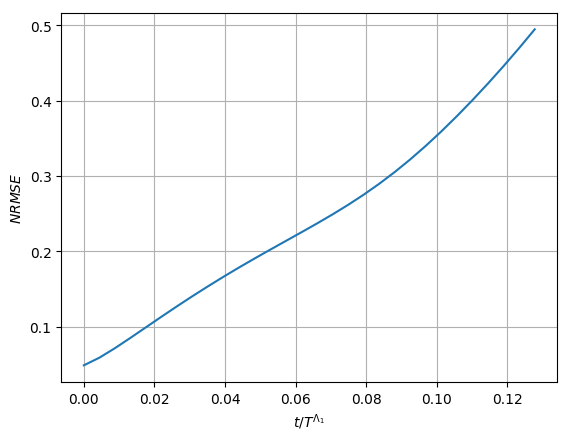

VPT is 0.1277533039647417


In [17]:
nrmse = NRMSE(test_field, estimated_field)
nrmse_ = nrmse[nrmse<=tol]

time_ref = (t_test - t_test[0])/lambda_1
t_ref = time_ref[nrmse<=tol]
VPT = t_ref[-1]

plt.plot(t_ref, nrmse_)
plt.ylabel(r"$NRMSE$")
plt.xlabel(r"$t/T^{\Lambda_1}$")
plt.grid(True)
plt.savefig(os.path.join(save_path, f"nmrse_along_time_{label}.png"))
plt.show()

print(f"VPT is {VPT}")

nrse = NRSE(test_field, estimated_field)

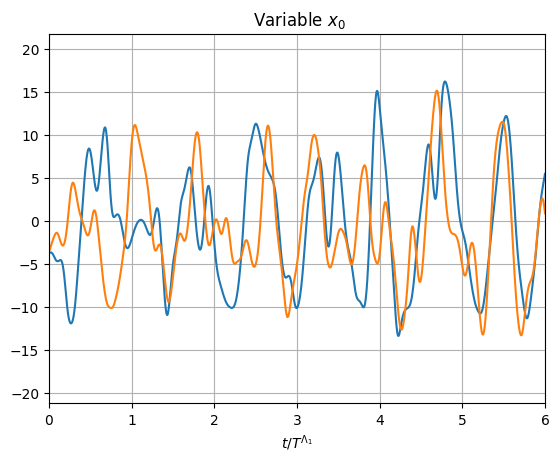

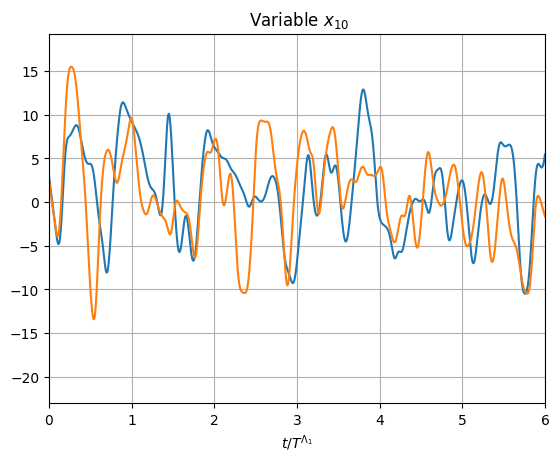

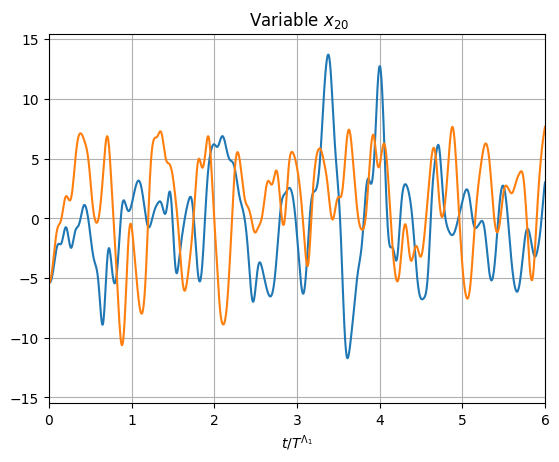

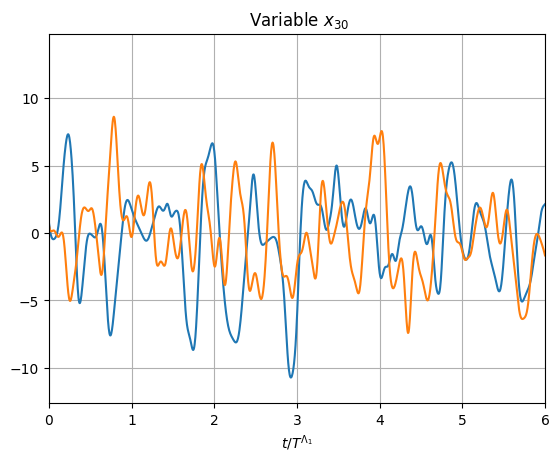

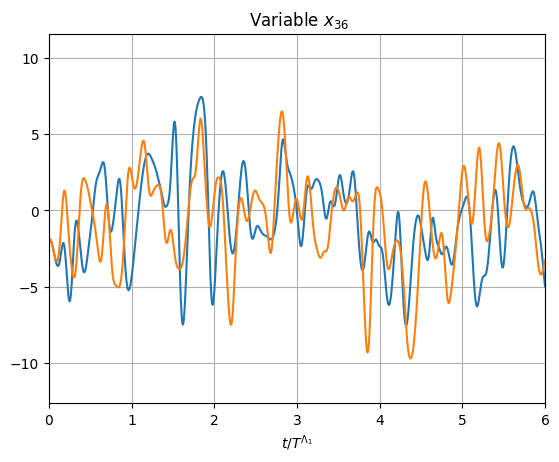

In [18]:
vars = [0, 10, 20, 30, K-1]

for vv in vars:
    plt.plot(time_ref, estimated_field[:, vv])
    plt.plot(time_ref, test_field[:, vv])
    plt.title(rf" Variable $x_{str({vv})}$")
    plt.xlabel(r"$t/T^{\Lambda_1}$")
    plt.xlim(0, 6)
    plt.grid(True)
    plt.savefig(os.path.join(save_path, f"evaluation_{vv}_{label}"))
    plt.show()

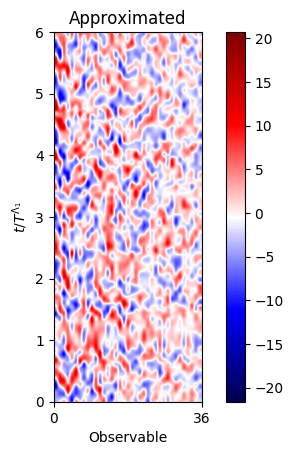

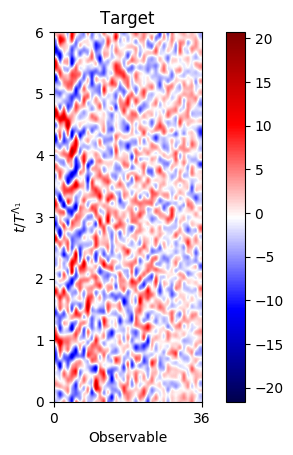

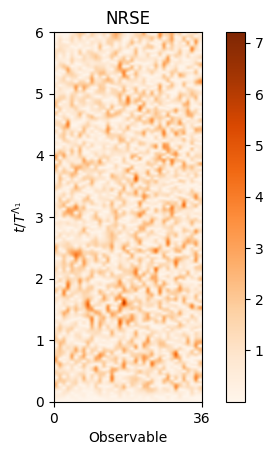

In [19]:
t_plot = time_ref
x_plot = np.arange(0, K)
aspect = 15
extent = x_plot.min(), x_plot.max(), t_plot.min(), t_plot.max()

color_norm = Normalize(vmin=test_field.min(), vmax=test_field.max())

plt.imshow(np.flip(estimated_field,axis=0), extent=extent, aspect=aspect, cmap='seismic',
           interpolation='bilinear',
           norm=color_norm)
plt.colorbar()
plt.title("Approximated")
plt.xlabel("Observable")
plt.ylabel(r"$t/T^{\Lambda_1}$")
plt.xticks([0, K-1])
plt.ylim(0, 6)
plt.savefig(os.path.join(save_path, f"approximated_2D_plot_{label}.png"))
plt.show()

plt.imshow(np.flip(test_field, axis=0), extent=extent, aspect=aspect, cmap='seismic',
           interpolation='bilinear',
           norm=color_norm)
plt.colorbar()
plt.title("Target")
plt.xlabel("Observable")
plt.ylabel(r"$t/T^{\Lambda_1}$")
plt.xticks([0, K-1])
plt.ylim(0, 6)
plt.savefig(os.path.join(save_path, f"exact_2D_plot_{label}.png"))
plt.show()

plt.imshow(np.flip(nrse, axis=0), extent=extent, aspect=aspect,
           interpolation='bilinear',
           cmap='Oranges',
           )
plt.colorbar()
plt.title("NRSE")
plt.xlabel("Observable")
plt.ylabel(r"$t/T^{\Lambda_1}$")
plt.xticks([0, K-1])
plt.ylim(0, 6)
plt.savefig(os.path.join(save_path, f"nrse_2D_plot_{label}.png"))
plt.show()